In [1]:
%matplotlib inline
#%matplotlib nbagg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray
import glob
import matplotlib.colors as colors
from matplotlib import cm, animation
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import palettable
from palettable.colorbrewer.sequential import YlOrRd_9,RdPu_9
from palettable.colorbrewer.diverging import RdYlGn_10_r
from wrf import getvar, ALL_TIMES
from netCDF4 import Dataset
from matplotlib.animation import FuncAnimation

import scipy.stats as stats

#### Load data

In [2]:
path = '/ocean/projects/ees210014p/xjliu/Xingu_exp_10day/'
year=2001
file = path+'post_processing/dif.energy.'+str(year)+'.mediumclearing.ndays.nc'
print(file)
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
    lats=ds['XLAT'][0,:,0]
    lons=ds['XLONG'][0,0,:]

### LU_INDEX
file = path+'Xingu_2005_bigclearing/3Dfields_d01_2005-11-10_00:00:00'
print(file)
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    luindex=ds1['LU_INDEX'][0,:,:]

/ocean/projects/ees210014p/xjliu/Xingu_exp_10day/post_processing/dif.energy.2001.mediumclearing.ndays.nc
/ocean/projects/ees210014p/xjliu/Xingu_exp_10day/Xingu_2005_bigclearing/3Dfields_d01_2005-11-10_00:00:00


#### Show the forests region (luindex<=5) and savanna region (Luindex=8[woody savanna],9,10[grassland])

Text(0, 0.5, 'longitude')

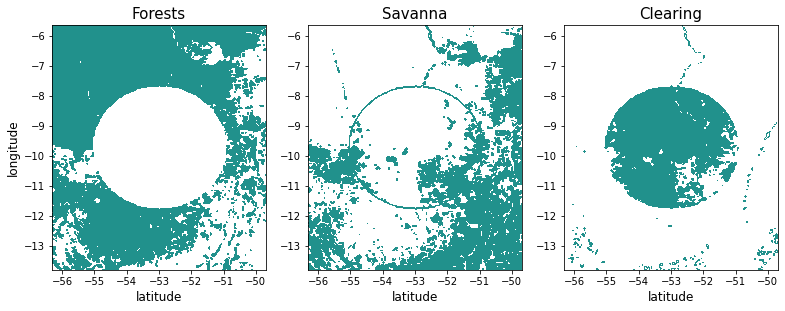

In [3]:
fig,ax = plt.subplots(1,3,figsize=(13,4.5))
ax[0].set_title('Forests',fontsize=15)
ax[0].contourf(lons,lats,luindex,levels=[0,5])

ax[1].set_title('Savanna',fontsize=15)
ax[1].contourf(lons,lats,luindex,levels=[7,11])

ax[2].set_title('Clearing',fontsize=15)
ax[2].contourf(lons,lats,luindex,levels=[11.9,12.1])

for ii in range(3):
    ax[ii].set_xlabel('latitude',fontsize=12)
ax[0].set_ylabel('longitude',fontsize=12)


In [6]:
print(lats.min())
print(lats.max())
print(lons.max())
print(lons.min())

<xarray.DataArray 'XLAT' ()>
array(-13.79580688)
Coordinates:
    XTIME    float32 0.0
<xarray.DataArray 'XLAT' ()>
array(-5.65454102)
Coordinates:
    XTIME    float32 0.0
<xarray.DataArray 'XLONG' ()>
array(-49.69721985)
Coordinates:
    XTIME    float32 ...
<xarray.DataArray 'XLONG' ()>
array(-56.30278015)
Coordinates:
    XTIME    float32 ...


In [22]:
# Show the clearing region (luindex=12), forests region (luindex<=5) and savanna region (Luindex=8[woody savanna],9,10[grassland])
year1=np.arange(2001,2010)
years=np.append(year1,np.arange(2011,2021))
for ii, year in enumerate(years):
    file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
    with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
        pass
    ### Mask using LUindex, forests
    #savanna=ds['LH'][39::24,10:-10,10:-10].where((luindex[10:-10,10:-10]>6)&(luindex[10:-10,10:-10]<11)) # Savanna
    #savanna=ds['LH'][39::24,20:-20,20:-20].where((luindex[20:-20,20:-20]<=5)) # Forests
    savanna=ds['LH'][9*24+15,:,:].where((luindex==12)) # clearing

    lh = np.ndarray.flatten(savanna.values)
    lh = lh[~np.isnan(lh)]

    mean,std=stats.norm.fit(lh) 
    print(year, mean, std)

2001 -10.059221 208.78302
2002 -51.41435 151.17313
2003 -46.380196 221.5195
2004 -2.9975114 159.42305
2005 -124.3984 235.17387
2006 22.872583 198.9564
2007 -101.74196 222.23038
2008 -75.1942 204.49765
2009 -23.465775 167.98228
2011 62.218327 215.8535
2012 -29.133959 206.99681
2013 26.17424 168.58289
2014 12.901653 135.22833
2015 -26.716335 109.51858
2016 -34.006622 154.02458
2017 -6.3928676 202.29558
2018 -7.79388 205.65173
2019 -71.40754 211.80748
2020 -134.20306 229.24142


In [15]:
def pdf_Xingu(landtype,xlim, ylim,time,day):
    ## landtype: forest, savanna, clearing
    ## time: a specific time, or all
    ## day: a specific day, or all
    ## xlim and ylim in the format [aa,bb]
    fig,axes = plt.subplots(4,5,figsize=(15,12),sharex=True,sharey=True)
    axes = axes.ravel()   
    year1=np.arange(2001,2010)
    years=np.append(year1,np.arange(2011,2021))

    for ii, year in enumerate(years):
        file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
        with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
            pass

        ### Mask using LUindex, forests
        #savanna=ds['LH'].where((luindex>6)&(luindex<11)) # Savanna
        #savanna=ds['LH'].where((luindex>=5)) # Forests
       
        if time=='All':
            print('All time samples will be used.')
            data_all = ds['LH']
        elif day=='All':
            print('Time '+str(time)+' of all the days will be used.')
            data_all = ds['LH'][time::24,:,:]
        else:
            print('Time '+str(time)+' of Day '+str(day)+' will be used.')
            data_all = ds['LH'][(day-1)*24+time,:,:]
            
        if landtype=='clearing':
            data=data_all.where((luindex==12)) # clearing
        elif landtype=='forest':
            data=data_all.where((luindex<=5)) # forest
        elif landtype=='savanna':
            data=data_all.where((luindex>6)&(luindex<11)) # savanna
        else: 
            data=data_all
            print('Data of all the grids are used.')
            

        lh = np.ndarray.flatten(data.values)
        lh = lh[~np.isnan(lh)]

        mean,std=stats.norm.fit(lh) 
        
        x = np.linspace(-500,500,101)
        y = stats.norm.pdf(x, mean, std)
        axes[ii].hist(lh, 100, density=True,facecolor='green', alpha=0.5);
        axes[ii].plot(x, y)
        #axes[ii].plot([mean,mean],[0,0.03],color='k')
        ## add 99 percentile lines
        left,right = stats.norm.interval(0.99,mean,std) ### This is not the data. Add the percentile of the data instead. 
        axes[ii].plot([left,left],[-0.000,0.005],'r')
        axes[ii].plot([right,right],[-0.000,0.005],'r')
        axes[ii].text(-200,0.0012,''+str("%.1f" % left),color='r')
        axes[ii].text(right,0.0012,''+str("%.1f" % right),color='r')

        axes[ii].text(10,0.008,'mean='+str("%.1f" %mean),color='b',fontsize=15)

        axes[ii].set_xlim(xlim)
        axes[ii].set_ylim(ylim)
        axes[ii].set_title('Y'+str(year),loc='left',pad=-14)

        for ii in range(15,20):
             axes[ii].set_xlabel('LH [W/m^2]')
        for ii in range(0,20,5):
            axes[ii].set_ylabel('Fraction/Probability')
        
        fig.suptitle('Landtype '+landtype+'; Day '+str(day)+'; Hour '+str(time),fontsize=20,y=0.9)
        
        #fig.savefig('PDF_Landtype'+landtype+'_Day'+str(day)+'_Hour'+str(time)+'.png',format='png')
    

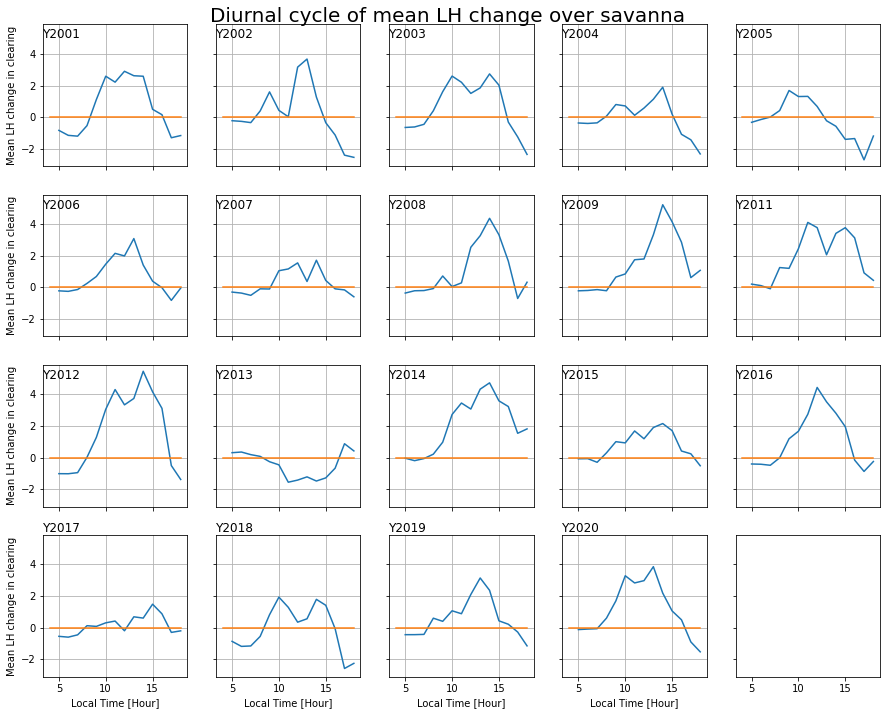

In [32]:
def pdf_Xingu_hourly(landtype):
    ## landtype: forest, savanna, clearing
    ## show the diurnal cycle of mean LH of day2-10 of each year
    fig,axes = plt.subplots(4,5,figsize=(15,12),sharex=True,sharey=True)
    axes = axes.ravel()   
    year1=np.arange(2001,2010)
    years=np.append(year1,np.arange(2011,2021))
    mean_all = np.empty(14)
    for ii, year in enumerate(years):
        file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
        with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
            pass
        
        if landtype=='clearing':
            data=ds['LH'].where((luindex==12)) # clearing
        elif landtype=='forest':
            data=ds['LH'].where((luindex<=5)) # forest
        elif landtype=='savanna':
            data=ds['LH'].where((luindex>6)&(luindex<11)) # savanna
        else: 
            data=ds['LH']
            print('Data of all the grids are used.')

        for tt,time in enumerate(range(4+3,18+3)): ### 5am to 6pm
            data_sel = data[24+time::24,:,:]  ### drop data of the first day. 
            lh = np.ndarray.flatten(data_sel.values)
            lh = lh[~np.isnan(lh)]

            mean,std=stats.norm.fit(lh) 
            mean_all[tt] = mean
                
        axes[ii].plot(np.arange(5,19),mean_all)
        axes[ii].plot([4,18],[0,0])
        axes[ii].grid()
        axes[ii].set_title('Y'+str(year),loc='left',pad=-14)
        
    for vv in range(15,19):
        axes[vv].set_xlabel('Local Time [Hour]')
    
    for vv in range(0,20,5):
        axes[vv].set_ylabel('Mean LH change in clearing')
        
        fig.suptitle('Diurnal cycle of mean LH change over '+landtype,fontsize=20,y=0.9)


pdf_Xingu_hourly('savanna')

Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.
Time 11 of all the days will be used.


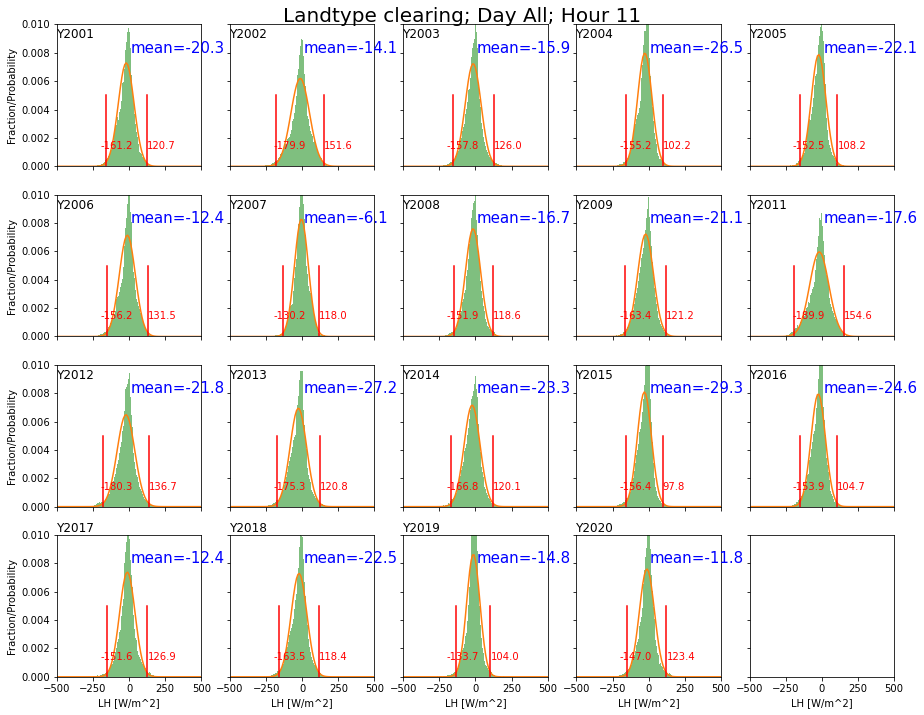

In [16]:
pdf_Xingu('clearing',[-500,500],[0,0.01],time=11,day='All')   

### 1. PDF of the differences of the entire region
Is the mean zero? Why? Need to mark the 99% percentile of the DATA. 

ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All time samples will be used.
Data of all the grids are used.
ok
All tim

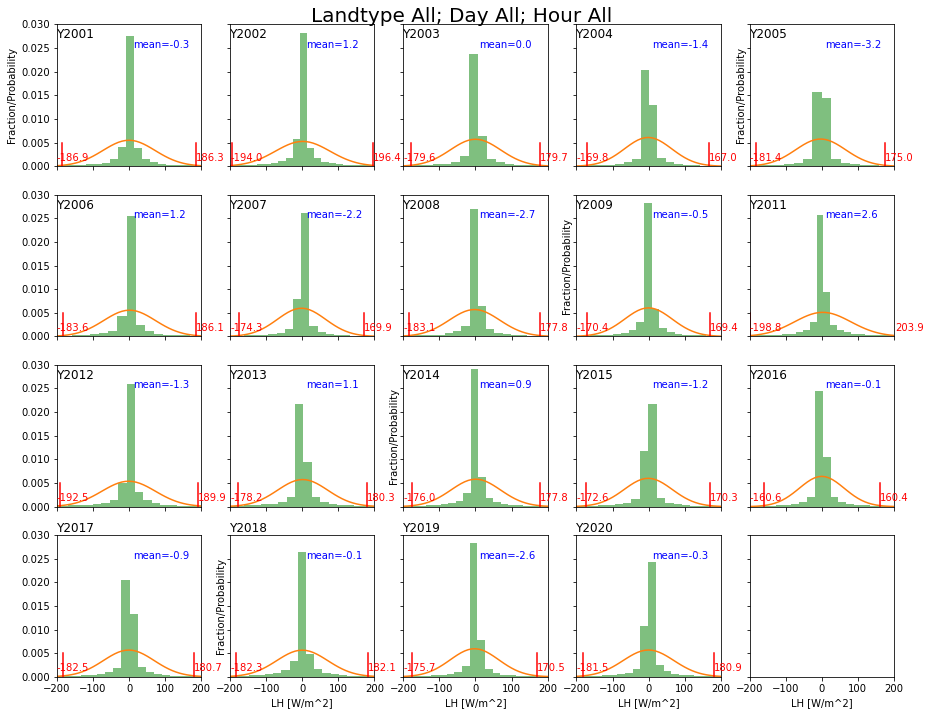

In [47]:
pdf_Xingu('All',[-200,200],[0,0.03],time='All',day='All')   

### 3. PDF of the differences of the FORESTS outside the clearing

ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.


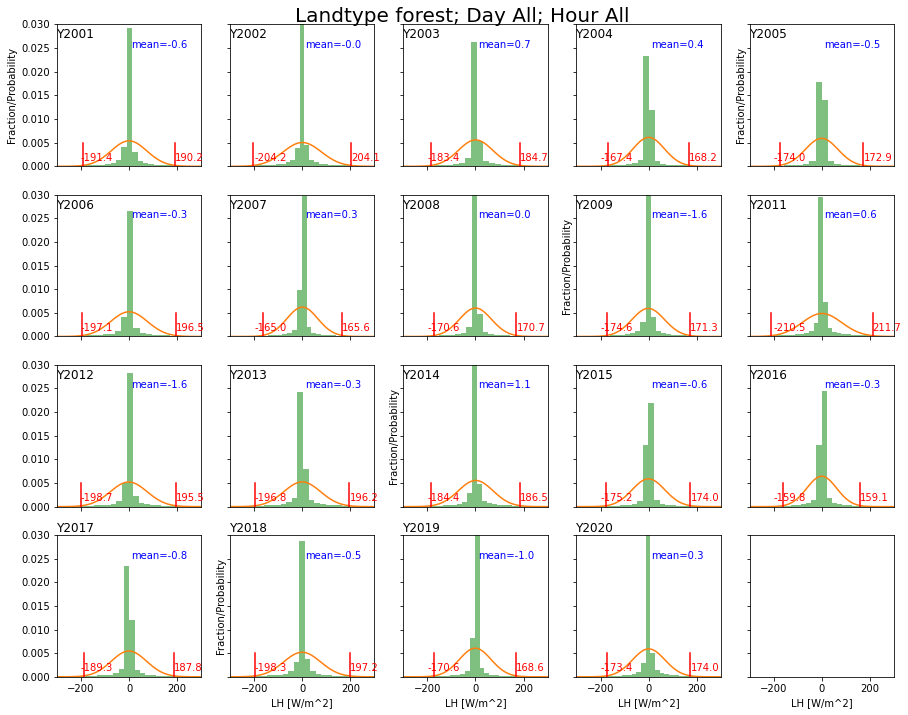

In [57]:
pdf_Xingu('forest',[-300,300],[0,0.03],time='All',day='All')   

### 4. PDF of the differences of the SAVANNA outside the clearing

ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.
ok
All time samples will be used.


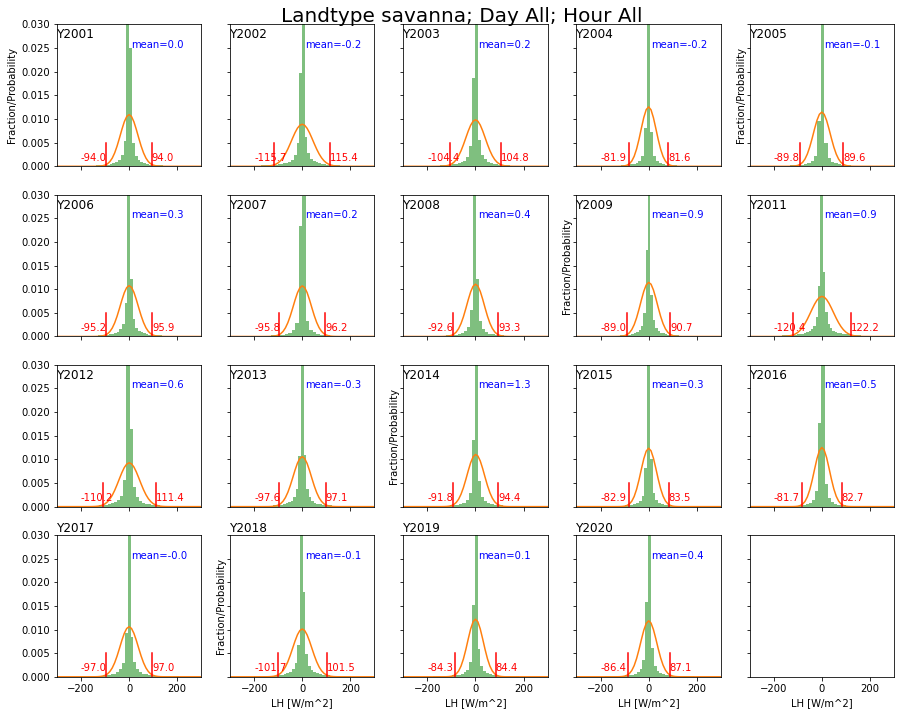

In [58]:
pdf_Xingu('savanna',[-300,300],[0,0.03],time='All',day='All')   

### Analyze the mean

In [18]:
def pdf_Xingu_noplot(landtype):
    ## landtype: forest, savanna, clearing
    ## Get the mean of [timeAlldayAll,time15dayAll,time15Day10] of a given landtype

    year1=np.arange(2001,2010)
    years=np.append(year1,np.arange(2011,2021))
    
    mean_all=np.empty((19,3)) ## 20years*3time_formats
    for ii, year in enumerate(years):
        file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
        with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
            pass
            
        if landtype=='clearing':
            data_all=ds['LH'].where((luindex==12)) # clearing
        elif landtype=='forest':
            data_all=ds['LH'].where((luindex<=5)) # forest
        elif landtype=='savanna':
            data_all=ds['LH'].where((luindex>6)&(luindex<11)) # savanna
        else: 
            data_all=ds['LH']
            print('Data of all the grids are used.')
        
        data_dayall_timeall = data_all
        data_dayall_time15 = data_all[16::24,:,:]
        data_day10_time15 = data_all[(10-1)*24+15,:,:]

        for jj in range(3):
            if jj==0:
                data=data_dayall_timeall
            elif jj==1:
                data=data_dayall_time15
            else:
                data=data_day10_time15
        
            lh = np.ndarray.flatten(data.values)
            lh = lh[~np.isnan(lh)]

            mean,std=stats.norm.fit(lh)         
            mean_all[ii,jj]=mean
        
    return mean_all

In [19]:
mean_clearing = pdf_Xingu_noplot('clearing')
mean_clearing[:,1]
T2m_mean=np.array([299.18588, 298.8395 , 298.69974, 299.43655, 299.65915, 298.67435,
       299.3545 , 299.56143, 298.9704 ,  297.72205, 298.89944,
       298.36868, 299.47723, 300.31873, 299.65042, 299.3113 , 299.05862,
       299.3292 , 299.45334])
np.corrcoef(mean_clearing[:,1],T2m_mean)

array([[ 1.        , -0.69604299],
       [-0.69604299,  1.        ]])

In [15]:
mean_clearing[:,1]

array([ -6.19893217,   6.49842358, -12.43856049, -30.85922432,
       -48.1177063 ,  14.03161526, -41.87017441, -47.24987411,
        -9.70894909,  28.48993492, -17.78701591,   8.44867516,
        -7.61617136, -14.61014366, -19.68271065, -16.33692932,
        -9.9053793 , -37.65141678, -27.52505684])

In [37]:
np.argsort(mean_clearing[:,1])

array([ 4,  7,  6, 17,  3, 18, 14, 10, 15, 13,  2, 16,  8, 12,  0,  1, 11,
        5,  9])

Text(0, 0.5, 'Mean of Differences in LH [W/m^2]')

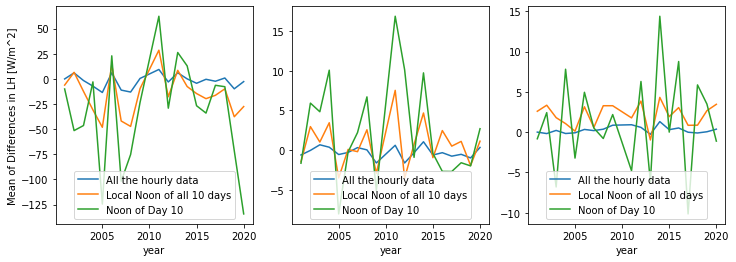

In [9]:
#mean_clearing = pdf_Xingu_noplot('clearing')
#mean_forest = pdf_Xingu_noplot('forest')
#mean_savanna = pdf_Xingu_noplot('savanna')

year1=np.arange(2001,2010)
years=np.append(year1,np.arange(2011,2021))
    
fig,axes = plt.subplots(1,3,figsize=(12,4),sharex=True)
axes = axes.ravel()  

for ii,ss in enumerate(['clearing','forest','savanna']):
    mean_st = globals()['mean_'+ss]
    axes[ii].plot(years,mean_st)
    axes[ii].legend(['All the hourly data','Local Noon of all 10 days','Noon of Day 10'],loc='lower center')
    axes[ii].set_xlabel('year')
axes[0].set_ylabel('Mean of Differences in LH [W/m^2]')

### check the difference between El Nino and La Nina years, using local noon of all 10 days. 

In [6]:
def pdf_Xingu_ENSO(landtype,years,xlim, ylim,time,day):
    ## landtype: forest, savanna, clearing
    ## time: a specific time, or all
    ## day: a specific day, or all
    ## xlim and ylim in the format [aa,bb]
    fig,axes = plt.subplots(4,5,figsize=(15,12),sharex=True,sharey=True)
    axes = axes.ravel()   
    
    for ii, year in enumerate(years):
        file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
        with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
            pass

        ### Mask using LUindex, forests
        #savanna=ds['LH'].where((luindex>6)&(luindex<11)) # Savanna
        #savanna=ds['LH'].where((luindex>=5)) # Forests
       
        if time=='All':
            print('All time samples will be used.')
            data_all = ds['LH']
        elif day=='All':
            print('Time '+str(time)+' of all the days will be used.')
            data_all = ds['LH'][time::24,:,:]
        else:
            print('Time '+str(time)+' of Day '+str(day)+' will be used.')
            data_all = ds['LH'][(day-1)*24+time,:,:]
            
        if landtype=='clearing':
            data=data_all.where((luindex==12)) # clearing
        elif landtype=='forest':
            data=data_all.where((luindex<=5)) # forest
        elif landtype=='savanna':
            data=data_all.where((luindex>6)&(luindex<11)) # savanna
        else: 
            data=data_all
            print('Data of all the grids are used.')
            

        lh = np.ndarray.flatten(data.values)
        lh = lh[~np.isnan(lh)]

        mean,std=stats.norm.fit(lh) 
        
        x = np.linspace(-500,500,101)
        y = stats.norm.pdf(x, mean, std)
        axes[ii].hist(lh, 100, density=True,facecolor='green', alpha=0.5);
        axes[ii].plot(x, y)
        #axes[ii].plot([mean,mean],[0,0.03],color='k')
        ## add 99 percentile lines
        left,right = stats.norm.interval(0.99,mean,std) ### This is not the data. Add the percentile of the data instead. 
        axes[ii].plot([left,left],[-0.000,0.005],'r')
        axes[ii].plot([right,right],[-0.000,0.005],'r')
        axes[ii].text(-200,0.0012,''+str("%.1f" % left),color='r')
        axes[ii].text(right,0.0012,''+str("%.1f" % right),color='r')

        axes[ii].text(10,0.008,'mean='+str("%.1f" %mean),color='b')

        axes[ii].set_xlim(xlim)
        axes[ii].set_ylim(ylim)
        axes[ii].set_title('Y'+str(year),loc='left',pad=-14)

        for ii in range(15,20):
             axes[ii].set_xlabel('LH [W/m^2]')
        for ii in range(0,20,5):
            axes[ii].set_ylabel('Fraction/Probability')
        
        fig.suptitle('Landtype '+landtype+'; Day '+str(day)+'; Hour '+str(time),fontsize=20,y=0.9)
        
        #fig.savefig('PDF_Landtype'+landtype+'_Day'+str(day)+'_Hour'+str(time)+'.png',format='png')
    

Time 15 of all the days will be used.
Time 15 of all the days will be used.
Time 15 of all the days will be used.
Time 15 of all the days will be used.
Time 15 of all the days will be used.


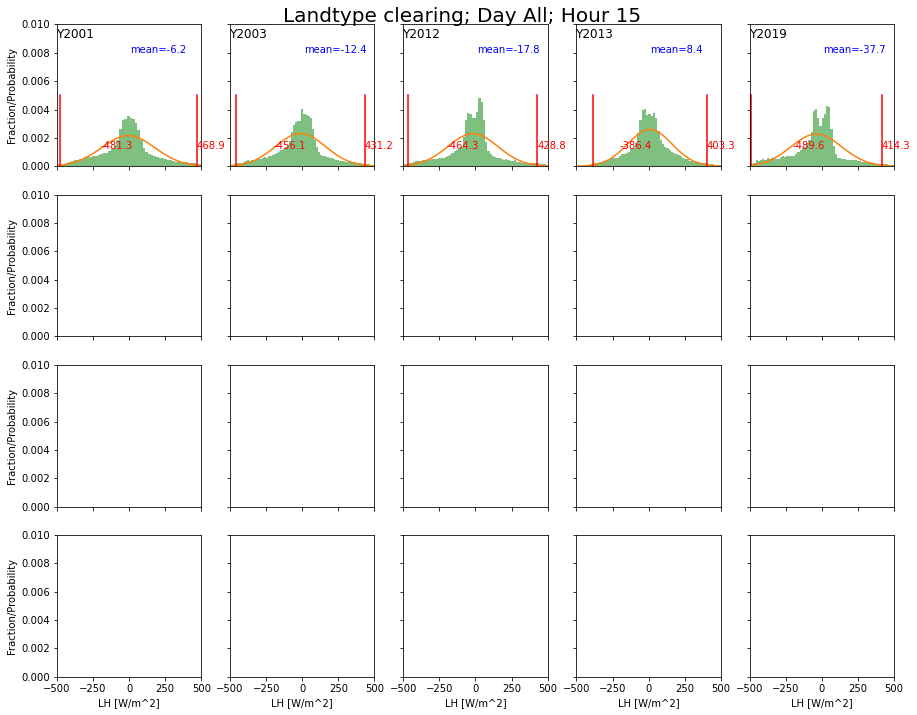

In [7]:
nino_year = [2002,2004,2006,2009,2014,2015,2018]
nina_year = [2005,2007,2008,2011,2016,2017,2020]
neutral_year = [2001,2003,2012,2013,2019]

pdf_Xingu_ENSO('clearing',neutral_year, [-500,500],[0,0.01],time=15,day='All')   

In [11]:
nino=np.array([-0.3,1.1,0.4,0.7,-.8,0.9,-1.6,-0.7,1.6,-1.0,-.2,-.3,0.7,2.6,-0.6,-1.0,0.8,0.5,-1.2])
nino.shape

(19,)

In [18]:
np.corrcoef(nino,mean_savanna[:,1])

array([[1.        , 0.23946766],
       [0.23946766, 1.        ]])